# Rolling Planning mit Flow Time

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

from src.utils.production_process import initialize as init
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Extern
import pandas as pd
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60*10 # 10 min

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")

## Generierung des Datensatzes für 5 Tage (Ankunft)

In [4]:
day_count = 5

df_jssp, df_jobs_times = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = day_count, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time
0,J0,8,75,1440
1,J1,6,123,1440
2,J2,0,187,1440
3,J3,2,231,1440
4,J4,3,271,1440
5,J5,1,472,1440
6,J6,9,749,1440
7,J7,5,877,1440
...,...,...,...,...
105,J105,1,6902,7200


In [5]:
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J0,8,0,M00,76
1,J0,8,1,M01,69
2,J0,8,2,M03,76
3,J0,8,3,M05,51
4,J0,8,4,M02,85
5,J0,8,5,M09,11
6,J0,8,6,M06,40
7,J0,8,7,M07,89
...,...,...,...,...,...
1122,J112,9,2,M02,61


## Params

In [6]:
# fix
day_length = 1440

In [7]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [8]:
day_numb = 0

In [9]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440

In [10]:
# I)
df_jssp_curr, df_times_curr = process_filter.jobs_by_arrival_window(df_jobs_times, df_jssp, day_start, day_end)
df_jssp_curr

,Job,Routing_ID,Operation,Machine,Processing Time
0,J0,8,0,M00,76
1,J0,8,1,M01,69
2,J0,8,2,M03,76
3,J0,8,3,M05,51
4,J0,8,4,M02,85
5,J0,8,5,M09,11
6,J0,8,6,M06,40
7,J0,8,7,M07,89
...,...,...,...,...,...
162,J16,6,2,M03,61


In [11]:
df_times_curr 

,Job,Routing_ID,Arrival,Ready Time
0,J0,8,75,1440
1,J1,6,123,1440
2,J2,0,187,1440
3,J3,2,231,1440
4,J4,3,271,1440
5,J5,1,472,1440
6,J6,9,749,1440
7,J7,5,877,1440
8,J8,4,936,1440
9,J9,7,951,1440


### Scheduling

In [12]:
df_schedule = lp_ft_schedule.solve_jssp(df_jssp_curr, df_times_curr, solver= "HiGHS", var_cat="Integer", msg=False, timeLimit=max_time, gapRel= 0.02)
df_schedule

BigM: 10000

Solver-Informationen:
  Summe Flow Times        : 10909.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1547
  Anzahl Constraints      : 2890
  Laufzeit                : ~600.12 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J0,8,0,75,M00,75.0,76.0,76.0,151.0
1,J0,8,1,75,M01,169.0,69.0,163.0,238.0
2,J0,8,2,75,M03,361.0,76.0,362.0,437.0
3,J0,8,3,75,M05,437.0,51.0,413.0,488.0
4,J0,8,4,75,M02,492.0,85.0,502.0,577.0
5,J0,8,5,75,M09,605.0,11.0,541.0,616.0
6,J0,8,6,75,M06,616.0,40.0,581.0,656.0
7,J0,8,7,75,M07,656.0,89.0,670.0,745.0
...,...,...,...,...,...,...,...,...,...
162,J9,7,2,951,M01,1086.0,46.0,181.0,1132.0


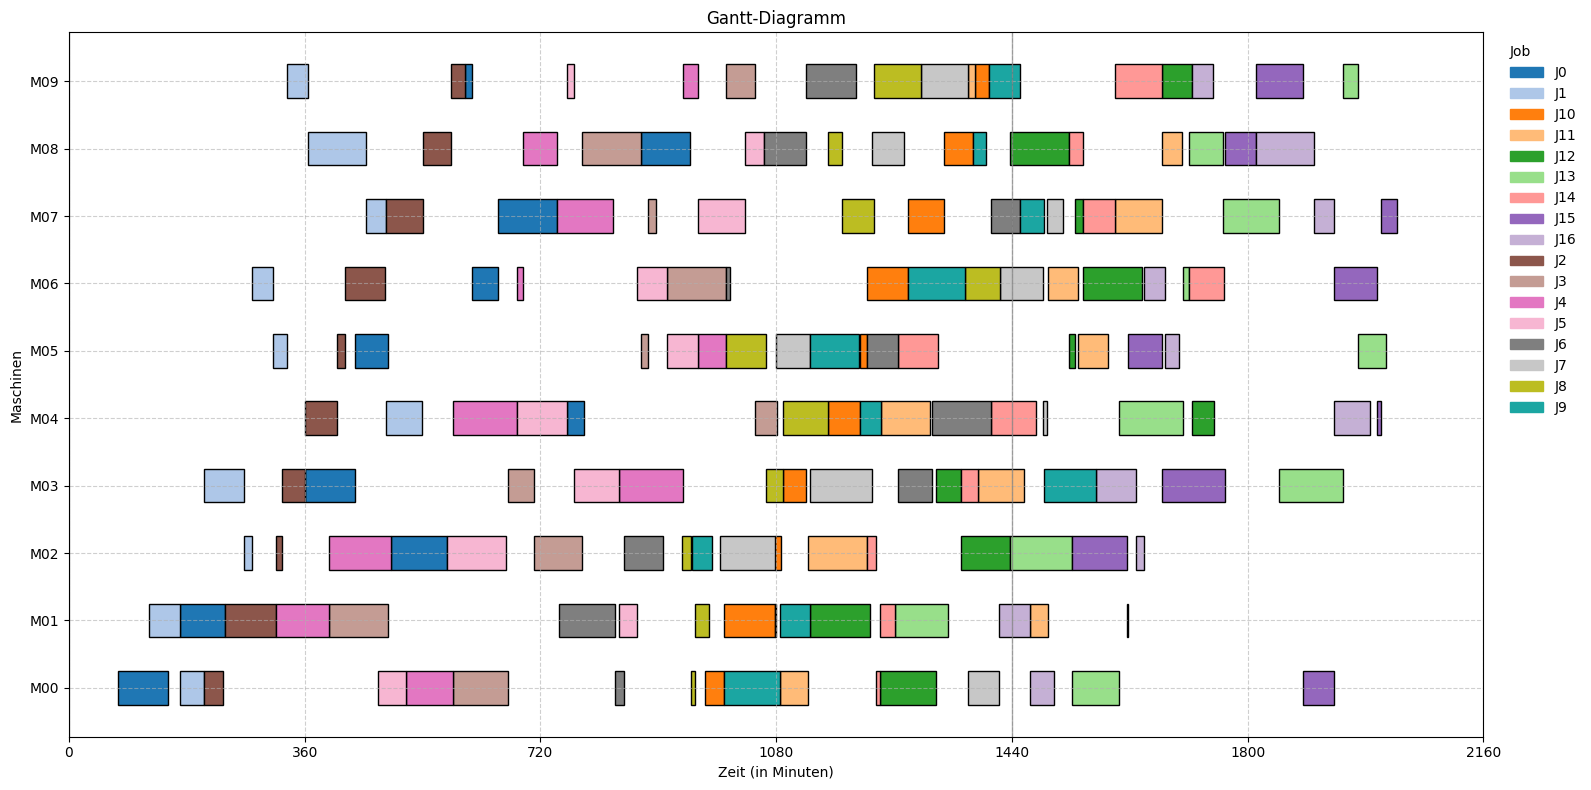

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### Simulation

In [14]:
simulation = ProductionSimulation(df_schedule, sigma=0.25)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[Day 0 01:15:00] Job J0 started on M00
[Day 0 02:03:00] Job J1 started on M01
[Day 0 02:26:44] Job J0 finished on M00 (after 71 minutes 44 seconds)
[Day 0 02:45:10] Job J1 finished on M01 (after 42 minutes 10 seconds)
[Day 0 02:49:00] Job J0 started on M01
[Day 0 02:49:00] Job J1 started on M00
[Day 0 03:16:35] Job J1 finished on M00 (after 27 minutes 36 seconds)
[Day 0 03:26:00] Job J2 started on M00
[Day 0 03:26:00] Job J1 started on M03
[Day 0 03:54:09] Job J2 finished on M00 (after 28 minutes 10 seconds)
[Day 0 04:05:30] Job J0 finished on M01 (after 76 minutes 30 seconds)
[Day 0 04:05:30] Job J2 started on M01
[Day 0 04:33:32] Job J1 finished on M03 (after 67 minutes 32 seconds)
[Day 0 04:33:32] Job J1 started on M02
[Day 0 04:44:28] Job J1 finished on M02 (after 10 minutes 56 seconds)
[Day 0 04:44:28] Job J1 started on M06
[Day 0 05:23:39] Job J1 finished on M06 (after 39 minutes 10 seconds)
[Day 0 05:23:39] Job J1 started on M05
[Day 0 05:50:16] Job J2 finished on M01 (after 104

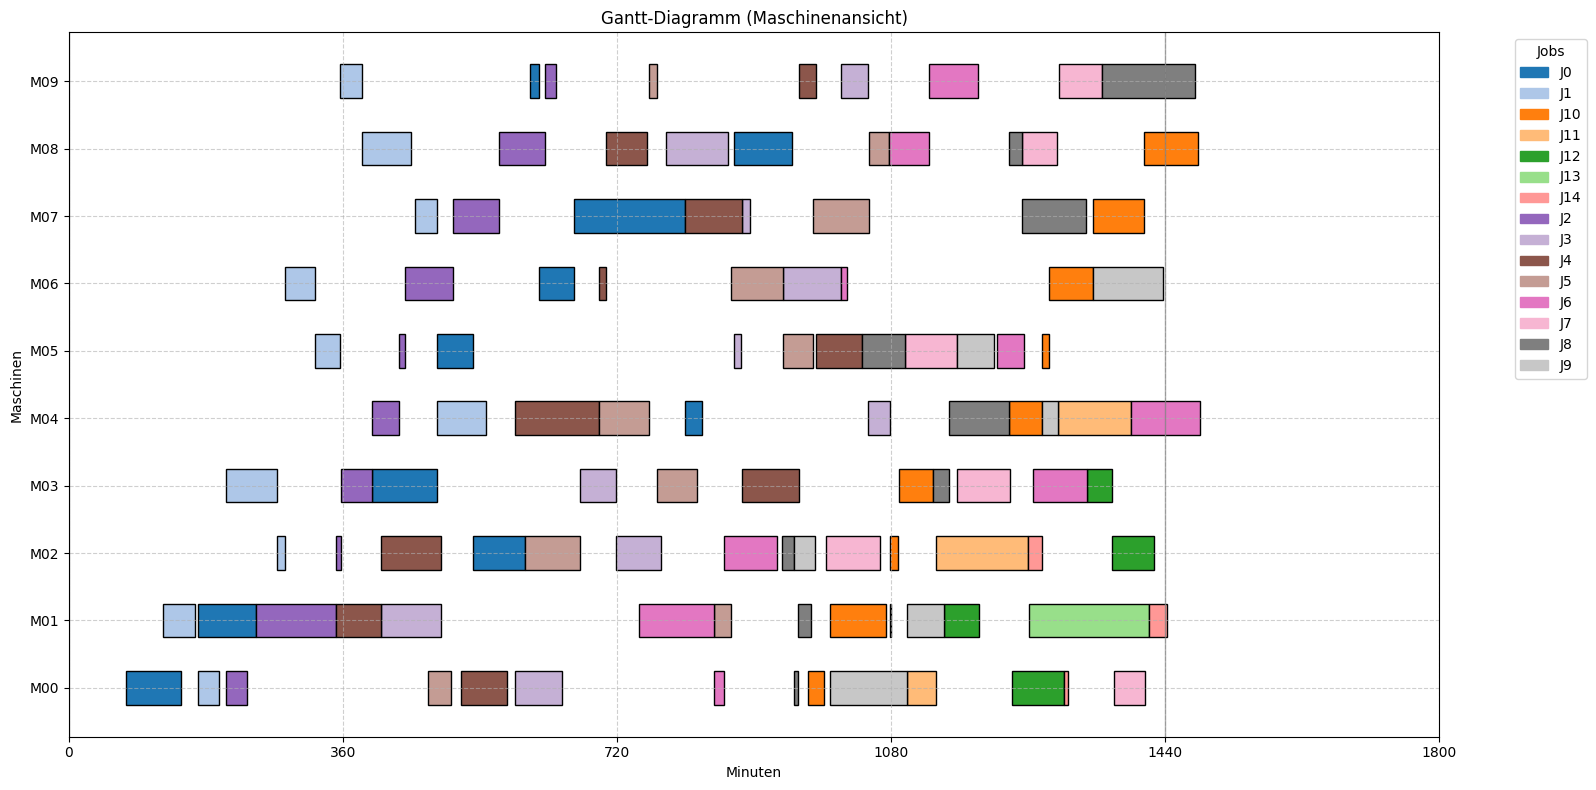

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution)
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J10,0,9,971,M09,1384.0,21.0,434.0,1405.0
1,J11,1,3,976,M09,1373.0,11.0,408.0,1384.0
2,J11,1,4,976,M03,1389.0,69.0,482.0,1458.0
3,J11,1,5,976,M01,1467.0,28.0,519.0,1495.0
4,J11,1,6,976,M06,1495.0,46.0,565.0,1541.0
5,J11,1,7,976,M05,1541.0,46.0,611.0,1587.0
6,J11,1,8,976,M07,1598.0,72.0,694.0,1670.0
7,J11,1,9,976,M08,1670.0,30.0,724.0,1700.0
...,...,...,...,...,...,...,...,...,...
51,J7,5,7,877,M06,1422.0,65.0,610.0,1487.0


#### Export

In [17]:
export_data_path = get_path("data", "flowtime")

In [18]:
df_jssp.to_csv(export_data_path / "02LP_all_jssp.csv", index = False)
df_jobs_times.to_csv(export_data_path / "02LP_all_times.csv", index = False)

In [19]:
df_schedule.to_csv(export_data_path / "02LP_init_schedule.csv", index = False)
df_execution.to_csv(export_data_path / "02LP_execution.csv", index = False)
df_plan_undone.to_csv(export_data_path / "02LP_init_undone.csv", index = False)